# 5. Test set evaluation 
We now use top models from the grid search to deploy on test

In [2]:
%load_ext autoreload
%autoreload 2

Note: the below is similar to the code seen in "protein-eval.py", use the selected models in notebook #4 to hardcode model strings

In [3]:
encoder_list = ["COLLAPSE", "ESM", "AA"]
test_metrics = ["auprc"]
metal = 'ZN'
# hard coded for now from looking at top of ranked dataframe
encoder_top_models = { \
    'COLLAPSE': ('k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model', 0.9), \
    # 'COLLAPSE': ('k20_r0_cutoff4.00_alpha0.001_tau0.00_lamnan.model', 0.95), \
    'ESM': ('k30_r1_cutoff4.00_alpha0.500_tau1.00_lamnan.model', 0.0), \
    'AA': ('k21_r2_cutoff6.00_alphanan_taunan_lam1.00.model', 0.5)}

baseline_top_models = \
    {'COLLAPSE': ('COLLAPSE-ZN-8.0-0.0005', 0.7), \
    'ESM': ('ESM-ZN-8.0-0.0005', 0.4), \
    'AA': ('AA-ZN-8.0-0.0005', 0.6)}

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
def setup_figure(width=6, height=3):
    sns.set(style='white')
    sns.set_context('paper')
    plt.figure(figsize=(width,height))
pal = sns.color_palette('tab20')

In [5]:
from evaluation import test_eval, extract_params, get_test_metrics
import utils
import pandas as pd

In [6]:
base_df = []
for encoder in encoder_list:
    for model_thresh_pair in baseline_top_models[encoder]:
        best_model, best_thresh = baseline_top_models[encoder]
        results_dict = utils.deserialize(f'../data/baselines/{encoder}_test_results.pkl')
        df = get_test_metrics(results_dict, encoder, best_model, best_thresh, test_metrics)
        # add a "method" column to the df (K2, Attn, Prob)
        df["method"] = best_model.split("_")[0].title()
        base_df.append(df)
base_df = pd.concat(base_df)

In [7]:
# from evaluation import compute_seg_all_configs

# cache_dir = "/dfs/scratch1/gmachi/gcp_backup/k2/"
# Gs_dir = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/clean_Gs_"
# label_dict_path = "/dfs/scratch1/gmachi/gcp_backup/k2/refined_label_dicts/refined_test_labeldict-" 
# gts_path = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/gt_graphs_"

# test_df = compute_seg_all_configs(encoder_top_models, cache_dir, Gs_dir, gts_path, label_dict_path)

Note: the below cell takes about 8min to run

In [7]:
test_df = []
for encoder, (model_str, threshold) in encoder_top_models.items():
    results_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results_2/{encoder}-eval_results"
    model_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results_2/{encoder}-fitted_k2_models"
    processor_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results_2/{encoder}-fitted_k2_processors"
    linearized_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results_2/{encoder}-linearized_data"

    _,_,cutoff,_,_,_ = extract_params(model_str)

    if encoder == 'AA':
        g_encoder = 'COLLAPSE'
    else:
        g_encoder = encoder

    G_dir = f"../data/{g_encoder}_{metal}_{cutoff}_test_graphs_2"

    df = test_eval(model_str, threshold, test_metrics, model_cache_dir, processor_cache_dir, G_dir, gt_dir=None, label_dict=None, modality="graph", arm="test")
    df['method'] = 'K2'
    test_df.append(df)
test_df = pd.concat(test_df)

/tmp/ipykernel_84035/276564250.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_df = pd.concat(test_df)


In [8]:
combined_df = pd.concat([test_df, base_df])

mean_df = combined_df.groupby(['encoder', 'method','regime', 'metric'])['value'].mean().reset_index()
sem_df = combined_df.groupby(['encoder', 'method','regime', 'metric'])['value'].sem().reset_index()

mean_pvt = mean_df.pivot(index=['encoder', 'method', 'regime'], columns='metric', values='value')
mean_pvt = mean_pvt[test_metrics]

sem_pvt = sem_df.pivot(index=['encoder', 'method', 'regime'], columns='metric', values='value')
sem_pvt = sem_pvt[test_metrics]

#Save dfs
mean_pvt.to_csv('../data/all_test_results_mean-AUPRC_2.csv')
sem_pvt.to_csv('../data/all_test_results_sem-AUPRC_2.csv')
combined_df.to_csv('../data/all_test_results_points-AUPRC_2.csv') # graph-level results
test_df.to_csv('../data/k2_test_results_points-AUPRC_2.csv')  # k2 only


# Properties vs performance

In [14]:
from evaluation import compute_test_mrds, compute_test_rps, compute_test_mcs, compute_test_ccs

rps_dict = compute_test_rps(G_dir, gt_key='gt')
mrds_dict = compute_test_mrds(G_dir, gt_key='gt')
ccs_dict = compute_test_ccs(G_dir, gt_key='gt')
mcs_dict = compute_test_mcs(G_dir, gt_key='gt')

/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/oak/stanford/groups/rbaltman/aderry/K2/src/evaluation.py:506: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(size_cc) / len(size_cc) # prevalence / num CC


In [15]:
test_df['rp'] = test_df['datum_id'].map(rps_dict)
test_df['mrd'] = test_df['datum_id'].map(mrds_dict)
test_df['ccs'] = test_df['datum_id'].map(ccs_dict)
test_df['mcs'] = test_df['datum_id'].map(mcs_dict)
test_df['srp'] = test_df['rp'] / test_df['ccs']

In [16]:
test_df = test_df.reset_index(drop=True)

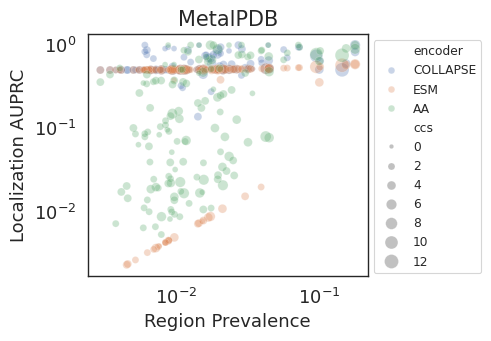

In [18]:
met = test_metrics[0]
setup_figure(5,3.5)
g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("MetalPDB", fontsize=15)
plt.tight_layout()
plt.savefig("../data/figures/enc_vs_prevalence_" + met + ".png", dpi=300, format='png')

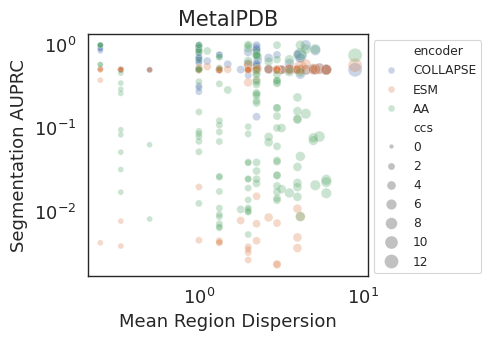

In [19]:
setup_figure(5,3.5)
g = sns.scatterplot(data=test_df, x="mrd", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Segmentation AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("MetalPDB", fontsize=15)
plt.tight_layout()
plt.savefig("../data/figures/enc_vs_mrd_" + met + ".png", dpi=300, format='png')

In [257]:
# g = sns.scatterplot(data=test_df, x="mcs", y="value", hue="encoder", size="ccs", sizes=(40, 300), alpha=0.4)
# # g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g.set_xscale("log")
# g.set_yscale("log")
# _ = g.set(xlabel="Mean Component Size", ylabel="Segmentation AUPRC")
# g.set_title("Impact of test-set MCS for segmentation")

In [258]:
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="mrd", sizes=(40, 300), alpha=0.4)
# # g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g.set_xscale("log")
# g.set_yscale("log")
# _ = g.set(xlabel="Region Prevalence", ylabel="Segmentation AUPRC")
# g.set_title("Impact of test-set RP for segmentation")

# plotting test set results

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils

# combined_df = pd.read_csv("/home/k2/K2/src/outputs/k2-test/all_test_results_points.csv")
# combined_df = pd.read_csv("/dfs/scratch1/gmachi/gcp_backup/k2/k2-test/all_test_results_points.csv")
combined_df = pd.concat([test_df, base_df])
combined_df['method'] = ['Prospector']*len(test_df) + ['GAT+GNNExplainer']*len(base_df)


In [10]:
combined_df.head()

,encoder,model,threshold,datum_id,regime,metric,value,method
0,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,5dmmA.pkl,all,auprc,0.508681,Prospector
1,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,4gmuA.pkl,all,auprc,NaN,Prospector
2,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,3kraA.pkl,all,auprc,NaN,Prospector
3,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,3i2bF.pkl,all,auprc,NaN,Prospector
4,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,2gmwA.pkl,all,auprc,0.543750,Prospector


In [11]:
combined_df[combined_df.metric == "auprc"].reset_index()

,index,encoder,model,threshold,datum_id,regime,metric,value,method
0,0,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,5dmmA.pkl,all,auprc,0.508681,Prospector
1,1,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,4gmuA.pkl,all,auprc,NaN,Prospector
2,2,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,3kraA.pkl,all,auprc,NaN,Prospector
3,3,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,3i2bF.pkl,all,auprc,NaN,Prospector
4,4,COLLAPSE,k15_r1_cutoff8.00_alpha0.500_tau4.00_lamnan.model,0.9,2gmwA.pkl,all,auprc,0.543750,Prospector
...,...,...,...,...,...,...,...,...,...
2049,252,AA,AA-ZN-8.0-0.0005,0.6,4likA,all,auprc,0.105263,GAT+GNNExplainer
2050,253,AA,AA-ZN-8.0-0.0005,0.6,1c7kA,all,auprc,0.045859,GAT+GNNExplainer
2051,254,AA,AA-ZN-8.0-0.0005,0.6,3edhA,all,auprc,0.056818,GAT+GNNExplainer
2052,255,AA,AA-ZN-8.0-0.0005,0.6,4h3sA,all,auprc,0.032841,GAT+GNNExplainer


In [12]:
combined_df.method.unique()

array(['Prospector', 'GAT+GNNExplainer'], dtype=object)

/tmp/ipykernel_84035/2910528919.py:10: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
/tmp/ipykernel_84035/2910528919.py:10: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.0}` instead.

  ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
/tmp/ipykernel_84035/2910528919.py:11: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vert

0.08860437005516353
0.08558087595903145
0.085614939119581
0.5770934484299504
0.3535019492368601
0
0


<Figure size 640x480 with 0 Axes>

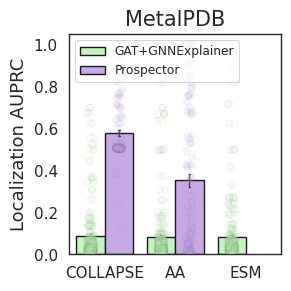

In [13]:
for met in test_metrics:
    subdf = combined_df[combined_df.metric == met].reset_index()
    plt.clf()
    # p=sns.color_palette("Set1")
    # colors at: https://xkcd.com/color/rgb/
    p=sns.xkcd_palette(["celadon","lavender","goldenrod","violet","vermillion","fuchsia","cerulean","mahogany"])
    if met == 'auprc':
        setup_figure(3,3)
        hue_order = ['GAT+GNNExplainer', 'Prospector']
        ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
        plt.title("MetalPDB", fontsize=15)
        ax.set_ylabel('Localization AUPRC', fontsize=13)
        ax.set_xlabel('')
        ax.tick_params(labelsize=11)
        for p in ax.patches:
            y = p.get_height()
            print(y)
        plt.legend(loc='upper left')
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3), sharey=True, gridspec_kw={'wspace': 0})
        sns.barplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax2, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="w")
        sns.stripplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax2, legend=False)
        # ax1.yaxis.set_label_position('left')

        ax2.set_title('  '+'class-1', loc='left')
        ax2.set_ylabel('')
        ax2.set_yticklabels([])
        ax2.legend_.remove()
    
        sns.barplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax1, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax1, legend=False)
        ax1.legend_.remove()
    
        # optionally use the same scale left and right
        xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
        ax1.set_xlim(xmax=xmax)
        ax2.set_xlim(xmax=xmax)

        ax1.invert_xaxis()  # reverse the direction
        ax1.tick_params(axis='y', labelleft=True, left=True, labelright=False, right=False)
        ax1.set_ylabel('')
        ax1.set_title('all data'+'  ', loc='right')

        plt.legend(loc=(-1.01,1.02))
        fig.suptitle(met, fontsize=15)
    
    plt.tight_layout()
    # plt.savefig("/home/k2/K2/src/outputs/k2-test/k2-vs-baseline_" + met + ".png", dpi=2000, format='png')
    plt.savefig("../data/figures/k2-vs-baseline_" + met + ".png", dpi=2000, format='png')
    plt.show()

In [32]:
combined_df[combined_df.regime == 'all'].groupby(['encoder','method'])['value'].describe()[['mean','std']]


mean       std
encoder  method                              
AA       GAT+GNNExplainer  0.085581  0.150307
         Prospector        0.353502  0.352881
COLLAPSE GAT+GNNExplainer  0.088604  0.153821
         Prospector        0.577093  0.153539
ESM      GAT+GNNExplainer  0.085615  0.148736

In [13]:
0.580702 - 0.088604

0.49209800000000004